In [5]:
import json
import pandas as pd
import numpy as np
from numpy import random as rand
import matplotlib.pyplot as plt
import utilities as utl
from tqdm import trange
from OptSegSI import optSegSI
import ruptures as rpt

In [6]:
FIG_SIZE = (12,5)

# Velib data

Load data

In [7]:
with open('data/data_velib.json') as json_file:
    data = json.load(json_file)
df = pd.DataFrame(np.array([float(s) if s != "" else float('nan') for s in data['y']]), columns = ['signal'], index = pd.to_datetime(data["x"]))
df.head()

,signal
2018-02-14,3179.0
2018-02-15,1425.0
2018-02-16,2943.0
2018-02-17,2661.0
2018-02-18,1988.0


Check for missing values and fill by linear interpolation

In [8]:
df.isna().any()

signal    True
dtype: bool

In [9]:
df.interpolate(method= 'linear', inplace=True)
df.isna().any()

signal    False
dtype: bool

Normalize the signal

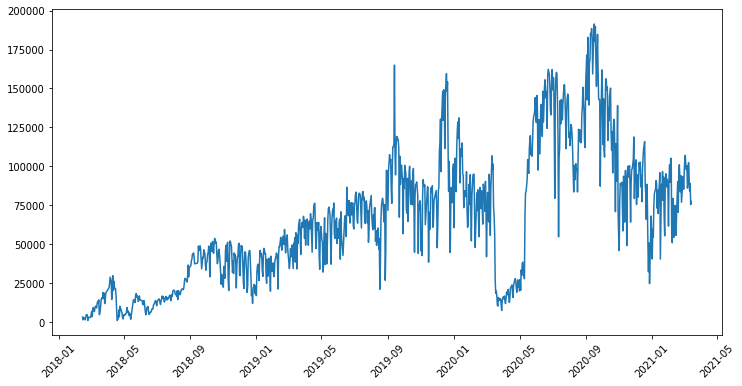

In [10]:
max_n_uses = np.max(df['signal'])
df["signal"] = df['signal']/max_n_uses
assert (df['signal'] <= 1).all()
plt.figure(figsize=(12,6))
plt.plot(df['signal'] * max_n_uses)
plt.xticks(rotation = 45)
plt.show()

Linear detrending

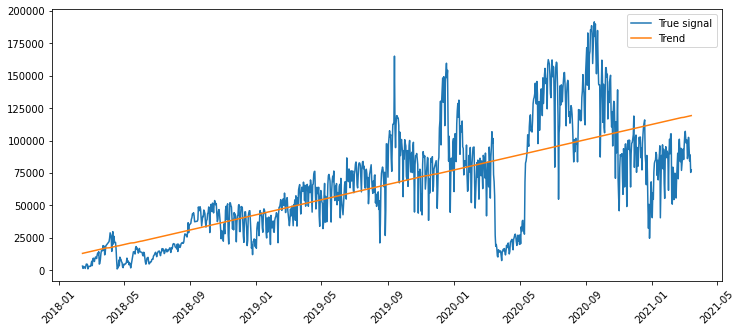

In [11]:
# Linear detrending
n_samples = len(df)
beta_matrix = np.stack([np.ones(n_samples), np.arange(n_samples)], axis=1)
assert beta_matrix.shape == (n_samples, 2)

alpha = np.linalg.lstsq(beta_matrix, df["signal"], rcond=None)[0]
assert alpha.shape == (2,)

df["trend"] = beta_matrix @ alpha

plt.figure(figsize=FIG_SIZE)
plt.plot(df["signal"] * max_n_uses, label="True signal")
plt.plot(df["trend"] * max_n_uses, label="Trend")
plt.xticks(rotation = 45)
plt.legend()
plt.savefig("plots/velib_trend.png", bbox_inches = "tight")
plt.show()

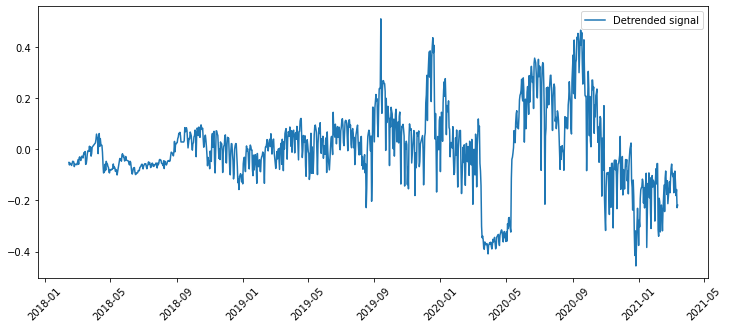

In [12]:
plt.figure(figsize=FIG_SIZE)
df["detrended_signal"] = df["signal"] - df["trend"]
plt.plot(df["detrended_signal"], label="Detrended signal")
plt.xticks(rotation = 45)
plt.legend()

We then remove remove the weekly periodicity by averaging the results over 7 days.

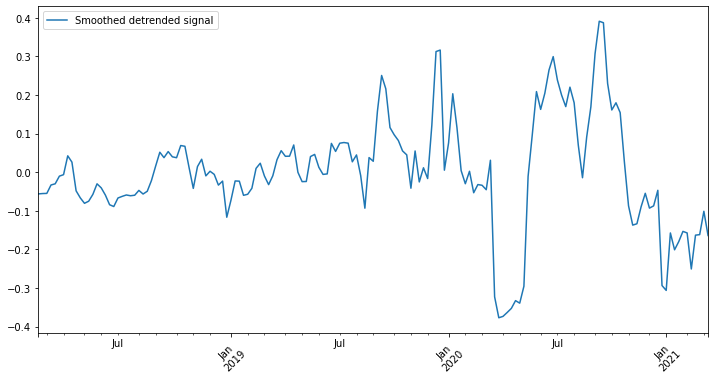

In [13]:
final_signal = df["detrended_signal"].resample("1W").mean()

plt.figure(figsize=(12,6))
final_signal.plot(label = "Smoothed detrended signal")
plt.xticks(rotation = 45)
plt.legend()

In [14]:
K = 3
N = len(final_signal)
Sigma = np.var(final_signal[-50:]) * np.identity(N)
p_values, tau_det = optSegSI(final_signal, N, K, Sigma, verbose=False, with_tau_det=True, recalculate_Sigma= True)

In [15]:
def plot_res(final_signal, tau_det, p_values, save_name = ""):
    fig,axes = rpt.display(final_signal, tau_det[1:], figsize = FIG_SIZE)

    #disgraceful code to add dates on xaxis a posteriori, should really copy and slightly modify rpt.display to take into account datetime index
    xtickind = [[int(t.get_text())] for t in axes[0].get_xticklabels()[1:]]
    xtickind = np.array(xtickind).flatten()
    xtickind = xtickind[np.where(xtickind< len(final_signal))]
    axes[0].set_xticklabels([0] + list(final_signal.index.strftime("%Y-%m-%d").to_numpy()[xtickind]))


    plt.xticks(rotation = 45)
    y_coord = 0.7*np.max(final_signal)
    for i in range(len(p_values)):
        
        plt.text(tau_det[i+1],y_coord,f'p = {np.exp(p_values[i]):.1e}',rotation=70)
    if save_name != "":
        plt.savefig("plots/" + save_name, bbox_inches = "tight")
    plt.plot()

<ipython-input-15-5ab00ca02ef2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([0] + list(final_signal.index.strftime("%Y-%m-%d").to_numpy()[xtickind]))


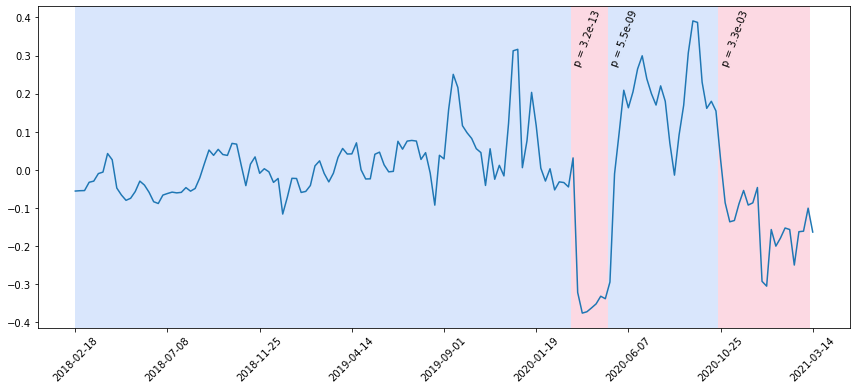

In [16]:
plot_res(final_signal, tau_det, p_values, save_name="velib_cp.png")

# Bike Lane Data

In [17]:
dtype = {
    'Identifiant du compteur' : object,
    'Comptage horaire': int,
    'Date et heure de comptage': object,
}
usecols = dtype.keys()
df = pd.read_csv('data/comptage-velo-donnees-compteurs.csv', sep=';', dtype=dtype, usecols=usecols)
df.head()

,Identifiant du compteur,Comptage horaire,Date et heure de comptage
0,100003096-101003096,23,2020-02-01T12:00:00+01:00
1,100003096-101003096,2,2020-02-01T03:00:00+01:00
2,100003096-101003096,1,2020-02-01T05:00:00+01:00
3,100003096-101003096,23,2020-02-01T17:00:00+01:00
4,100003096-101003096,1,2020-02-01T04:00:00+01:00


In [18]:
def get_weekly_data_counter(df, counter_id):
    counter_df = df[df['Identifiant du compteur'] == counter_id].drop('Identifiant du compteur', axis=1)
    datetime_format = '%Y-%m-%dT%H:%M:%S%z'
    counter_df['Date et heure de comptage'] = pd.to_datetime(counter_df['Date et heure de comptage'],
                                                format=datetime_format, errors='raise', exact=True, utc=True)
    weekly_df = counter_df.groupby(pd.Grouper(key='Date et heure de comptage', freq='W-MON'))['Comptage horaire']\
            .sum().reset_index().sort_values('Date et heure de comptage')
    return weekly_df['Comptage horaire']

In [19]:
counter_id = "100056330-103056330"
hourly_counts = df[df['Identifiant du compteur'] == counter_id].drop('Identifiant du compteur', axis=1)
datetime_format = '%Y-%m-%dT%H:%M:%S%z'
hourly_counts['Date et heure de comptage'] = pd.to_datetime(hourly_counts['Date et heure de comptage'],  format=datetime_format, errors='raise', exact=True, utc=True)
hourly_counts.set_index('Date et heure de comptage', inplace = True)
weekly_counts = hourly_counts.resample("1W").sum()

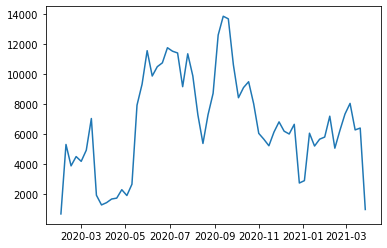

In [20]:
plt.plot(weekly_counts)

In [21]:
signal = weekly_counts["Comptage horaire"][1:-1]
K=3
sigma_frac = 1
n_samples = len(signal)
n_samples_sigma = int(n_samples * sigma_frac)
normalize = np.max(signal)
normalized_signal = signal/normalize
Sigma = np.var(normalized_signal[:n_samples_sigma]) * np.identity(n_samples_sigma)
p_values2, tau_det2 = optSegSI(normalized_signal, n_samples, K, Sigma, verbose=False, with_tau_det=True, recalculate_Sigma = True)

<ipython-input-15-5ab00ca02ef2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([0] + list(final_signal.index.strftime("%Y-%m-%d").to_numpy()[xtickind]))


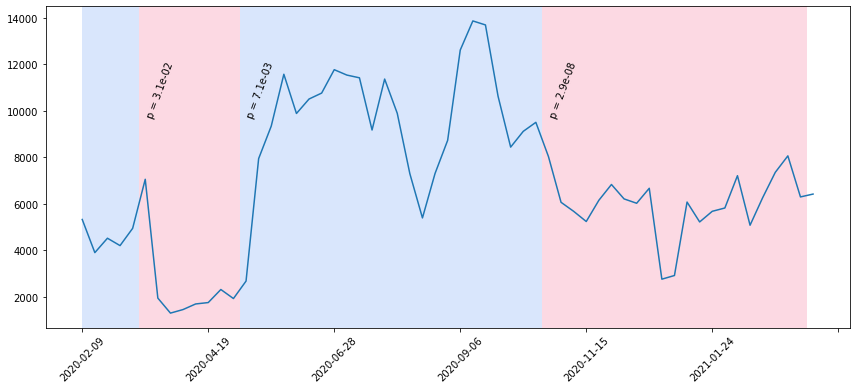

In [22]:
plot_res(signal, tau_det2, p_values2, save_name=f"Plot_sensor_{K}.png")